# Generación Automatica de Paletas de Colores con Algoritmos de Agrupamiento [K-Means, DBSCAN y Mean Shift]

## 1. Introducción y Selección de Datos

El objetivo de este proyecto es desarrollar una herramienta de Machine Learning no supervisado capaz de extraer paletas de colores estéticas, utilizando algoritmos de agrupamiento para deconstruir digitalmente obras de arte.

### Selección del Dataset: Diversidad Estilística y de Subgenero, Fauvismo, Expresionismo Abstracto, y Ukiyo-e

Para validar la robustez del modelo ante diferentes distribuciones de color, se ha seleccionado un conjunto de datos que abarca tres estilos artísticos distintivos: Fauvismo, Expressionism Abstracto y Ukiyo-e y tres (subgéneros) dentro de la tradición gráfica japonesa.

Fukei-ga (Paisajismo - Ej. Hiroshige): Caracterizado por grandes áreas de color plano, degradados suaves (Bokashi) y una paleta fría (azules de Prusia, verdes). Representa un desafío de baja entropía.
Musha-e (Pintura de Guerreros - Ej. Kuniyoshi): Escenas de batalla con alta saturación, múltiples patrones textiles y dominancia de rojos/negros. Representa un desafío de alta entropía y ruido visual.
Kacho-e (Pintura de Flores y Aves - Ej. Hokusai/Jakuchu): Enfoque en el detalle naturalista con alto contraste entre la figura y el fondo vacío.

Cada uno de los estilos y subgeneros seleccionados encarna una filosofía del color distinta, lo que los hace ideales para aplicar algoritmos de clustering orientados a la extracción de paletas cromáticas. 

- El **Fauvismo** prioriza relaciones de color audaces y no naturalistas, generando agrupaciones cromáticas claramente separables. 
- El **Expresionismo Abstracto** enfatiza la intensidad emocional y los grandes campos de color, donde suelen emerger clústeres tonales dominantes y gradientes expresivos.
- El **Ukiyo-e** se basa en áreas de color planas, cuidadosamente delimitadas, y en el uso recurrente de pigmentos, lo que produce paletas estructuradas y coherentes desde el punto de vista histórico.


En conjunto, estos movimientos estilisticos abarcan un amplio espectro —desde el uso controlado hasta el uso altamente expresivo del color— permitiendo evaluar los algoritmos de aggrupamiento en distribuciones cromáticas diversas y con distintas intenciones artísticas, y generando paletas tanto analíticamente significativas como visualmente atractivas.

**Motivación Técnica:** Se experimentan tres algoritmos de agrupamiento como herramienta de "ingeniería inversa", intentando recuperar los pigmentos originales de las paletas utilizadas para cada uno de los estilos. 

In [1]:
import math
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from PIL import Image
from sklearn.cluster import KMeans, DBSCAN, MeanShift, estimate_bandwidth
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
from sklearn.utils import resample

import time
import re

In [2]:
class ImageLoader:
    def __init__(self, images_folder_dir: Path | str = "images", include_root_files: bool = False):
        images_folder_dir = Path(images_folder_dir)
        self.cwd = Path.cwd()
        self.images_folder_path = (
            images_folder_dir if images_folder_dir.is_absolute()
            else (self.cwd / images_folder_dir)
        )
        self.valid_ext = {".jpg", ".jpeg", ".png"}
        self.image_files: List[Path] = []
        self.image_records: List[Tuple[Path, str]] = []
        self.include_root_files = include_root_files
        self._load_images_interleaved()

    def _iter_style_dirs(self):
        """Return first-level subdirectories under images/ (each is a style)."""
        root = self.images_folder_path
        if not root.exists():
            print(f"[WARN] Images folder not found: {root}")
            return []
        return [p for p in root.iterdir() if p.is_dir()]

    def _iter_style_files(self, style_dir: Path):
        """
        Yield files for a single style (recursively).
        """
        for p in style_dir.rglob("*"):
            if p.is_file() and p.suffix.lower() in self.valid_ext:
                yield p

    def _iter_root_files(self):
        """Optionally yield files directly under images/ as '__root__' style."""
        root = self.images_folder_path
        for p in root.iterdir():
            if p.is_file() and p.suffix.lower() in self.valid_ext:
                yield p

    def _load_images_interleaved(self, limit: int = None):
        """
        Build image_records by interleaving one file at a time from each style subfolder.
        """
        self.image_files.clear()
        self.image_records.clear()

        if not self.images_folder_path.exists():
            print(f"[WARN] Images folder not found: {self.images_folder_path}")
            return

        
        style_iters: List[Tuple[str, Iterator[Path]]] = []
        for d in self._iter_style_dirs():
            style_name = d.name
            style_iters.append((style_name, self._iter_style_files(d)))

        
        if self.include_root_files:
            style_iters.append(("__root__", self._iter_root_files()))

        
        active: List[Tuple[str, Iterator[Path]]] = style_iters[:]
        emitted = 0
        idx = 0

        while active:
            style_name, it = active[idx]
            try:
                path = next(it)
                self.image_records.append((path, style_name))
                self.image_files.append(path)

                emitted += 1
                if limit is not None and emitted >= limit:
                    break

                
                idx = (idx + 1) % len(active)

            except StopIteration:
                
                active.pop(idx)
                if active:
                    idx = idx % len(active)

        print(f"Found {len(self.image_files)} valid images (interleaved by style).")


    def plot_images(self):
        n_available = len(self.image_records)
        if n_available == 0:
            print("[INFO] No images to display.")
            return

        self.style_set = {style for _, style in self.image_records}
        self.n_styles = len(self.style_set)
        cols = max(1, min(self.n_styles, 5))
        limit = cols*4
        k = min(limit, n_available)
        images_to_show = self.image_records[:limit]
        n = len(images_to_show)
        rows = max(1, (n + cols - 1) // cols)
        
        fig = plt.figure(figsize=(15, 3.5 * rows))
        fig.suptitle("Paintings", fontsize=16, fontweight="bold")

        for i, (filepath, style) in enumerate(images_to_show):
            ax = plt.subplot(rows, cols, i + 1)
            try:
                with Image.open(filepath) as img:
                    ax.imshow(img)
                ax.set_title(f"{i + 1} · {style}", fontsize=10)
            except Exception as e:
                ax.text(0.5, 0.5, f"Failed: {filepath.name}\n{e}", ha="center", va="center", fontsize=8)
                ax.set_title(f"{i + 1} · {style} (failed)", fontsize=10)
            ax.axis("off")

        plt.tight_layout()
        plt.show()
        plt.close(fig)

## 2. Preprocesamiento de Imágenes (Pipeline)

Para que el algoritmo de *Machine Learning* pueda procesar la información visual de manera eficiente, las imágenes se transforman desde su representación matricial original (**Alto × Ancho × Canales**) a una estructura de datos tabular. Este proceso está encapsulado en la clase `FeatureExtractor` y está diseñado para equilibrar fidelidad cromática, eficiencia computacional y estabilidad numérica.

### Decisiones de Diseño del Pipeline

- **Carga y estandarización de la imagen**  
  Todas las imágenes se cargan y convierten explícitamente a **RGB** para garantizar consistencia en el número de canales, independientemente del formato original.

- **Redimensionamiento controlado**  
  Se limita el tamaño máximo del lado más largo de la imagen (`max_side`) manteniendo la proporción original. Esto reduce el número total de píxeles y el costo computacional, sin alterar de forma significativa la distribución global de colores.

- **Aplanado (*Flattening*)**  
  La imagen redimensionada se transforma de una matriz 3D (**H, W, 3**) a una matriz 2D (**N_pixeles, 3**). Esta operación elimina la información espacial, ya que el objetivo es agrupar colores por similitud cromática y no por su posición en la imagen.

- **Espacio de color (RGB / LAB)**  
  Por defecto, se utiliza el espacio **RGB**, al ser el formato nativo de visualización digital y permitir una interpretación directa de los centroides resultantes como colores hexadecimales. El diseño del pipeline permite extender fácilmente el procesamiento a espacios perceptualmente uniformes como **LAB** para análisis más avanzados.

- **Normalización**  
  Se escalan los valores de pixeles del rango entero **[0, 255]** al rango flotante **[0.0, 1.0]**. Esta etapa es crucial para la estabilidad numérica de algoritmos como **K-Means**, ya que mejora el cálculo de distancias euclidianas.

- **Submuestreo aleatorio**  
  Cuando el número de píxeles excede un umbral (`max_pixels_for_kmeans`), se realiza un submuestreo aleatorio reproducible. Esto permite trabajar con imágenes de alta resolución sin comprometer el rendimiento, manteniendo una representación estadísticamente robusta de la paleta cromática.

**Salida del Pipeline:**  
Una matriz de píxeles normalizados lista para ser utilizada directamente por algoritmos de *clustering* orientados a la extracción de paletas de color.


In [3]:
class FeatureExtractor:

    def __init__(self, max_side: int = 512, max_pixels_for_kmeans: int = 50_000, colorspace: str = "RGB"):
        
        self.max_side = max_side
        self.max_pixels_for_kmeans = max_pixels_for_kmeans
        self.colorspace = colorspace 
    
    def extract(self, image_path: Path) -> np.ndarray:
        raw_image = self._load_image(image_path)
        resized = self._resize(raw_image, self.max_side)
        flattened_pixels = self._flatten(resized)
        flattened_pixels = self._maybe_convert_colorspace(flattened_pixels)
        normalized_pixels = self._normalize(flattened_pixels)
        pixels = self._subsample(normalized_pixels, self.max_pixels_for_kmeans)
        return pixels

    def _load_image(self, path: Path):
        with Image.open(path) as img:
            return np.array(img.convert("RGB"))

    def _resize(self, image: np.ndarray, max_side: int):
        h, w = image.shape[:2]
        scale = min(1.0, max_side / max(h, w))
        if scale == 1.0:
            return image
        new_w, new_h = int(w * scale), int(h * scale)
        return np.array(Image.fromarray(image).resize((new_w, new_h), Image.Resampling.LANCZOS))

    def _maybe_convert_colorspace(self, pixels: np.ndarray):
        if self.colorspace.upper() != "LAB":
            return pixels
        h = int(np.sqrt(len(pixels)))  
        return pixels

    def _flatten(self, image: np.ndarray):
        return image.reshape(-1, 3)

    def _normalize(self, pixels: np.ndarray):
        return pixels.astype(np.float32) / 255.0


    def _subsample(self, pixels: np.ndarray, cap: int):
        if len(pixels) <= cap:
            return pixels
        idx = np.random.default_rng(42).choice(len(pixels), size=cap, replace=False)
        return pixels[idx]

## 3. Modelo de Agrupamiento y Selección de Hiperparámetros
El núcleo del proyecto experimentara con tres algoritmos de agrupamiento: K-Means, DBSCAN y Mean Shift.

### Estrategia de Selección Dinámica de K
Tal como exige el problema, el número de colores óptimo no es fijo; varía según la complejidad de cada imagen. Para automatizar esta decisión, se implementó un pipeline de búsqueda iterativa:,

1.  **Rango de Búsqueda:** Se evalúan valores de $k$ entre un mínimo y un máximo (ej. $k \in [3, 10]$).,
2.  **Métrica de Validación (Silhouette Score):** Se utiliza el Coeficiente de Silueta en lugar del \"Método del Codo\" (Elbow Method).,
    * *Justificación:* El método del Codo es subjetivo y difícil de automatizar. La Silueta proporciona una métrica escalar exacta `[-1, 1]` que mide qué tan similar es un píxel a su propio cluster en comparación con otros clusters. Esto penaliza el solapamiento, garantizando que los colores de la paleta sean visualmente distintos.

### Decisiones de Diseño del Módulo de K-Means

- **Rango dinámico de clústeres (k)**  
  En lugar de fijar un número arbitrario de colores, el algoritmo explora un rango de valores `k ∈ [min_k, max_k]`. Esto permite adaptarse a la complejidad cromática de cada imagen y evita imponer una estructura rígida sobre los datos.

- **Submuestreo para entrenamiento**  
  Cuando el número de píxeles es muy grande, se realiza un submuestreo aleatorio con un límite (`train_cap`) para entrenar el modelo. Esta estrategia reduce significativamente el costo computacional sin perder representatividad estadística de la distribución de colores.

- **Ajuste seguro del número de clústeres**  
  El número efectivo de clústeres (`k_eff`) se restringe dinámicamente para evitar configuraciones inválidas (por ejemplo, más clústeres que muestras disponibles), garantizando que el entrenamiento de K-Means sea estable.

- **Inicialización y reproducibilidad**  
  Se utilizan múltiples inicializaciones (`n_init=10`) y una semilla fija (`random_state`) para asegurar convergencia consistente y resultados reproducibles entre ejecuciones.

- **Evaluación basada en Silhouette Score**  
  Cada modelo entrenado se evalúa mediante el **Silhouette Score**, calculado sobre una muestra de los datos. Esta métrica cuantifica qué tan bien separados y compactos están los grupos de color, proporcionando un criterio objetivo para comparar distintos valores de *k*.

- **Manejo de casos degenerados**  
  El pipeline incluye protecciones explícitas contra situaciones en las que el *clustering* produce un solo grupo efectivo, en cuyo caso la métrica de *silhouette* no está definida y se penaliza el modelo.

***Salida del Proceso de Clustering***

El método `find_best_grouping` devuelve:

- **`best_model`**: el modelo de K-Means con la mejor separación cromática.
- **`best_score`**: el valor máximo del *Silhouette Score* obtenido.
- **`k_scores`**: un diccionario que asocia cada valor de *k* evaluado con su puntuación correspondiente.

Este enfoque permite seleccionar automáticamente una paleta de colores óptima, equilibrando expresividad visual y rigor estadístico.


In [4]:
class ColorGrouper:
    def __init__(self, min_k: int = 2, max_k: int = 10, train_cap: int = 50_000, random_state: int = 42):
    
        self.min_k = min_k
        self.max_k = max_k
        self.train_cap = train_cap
        self.random_state = random_state

    def _train(self, k: int, pixel_data: np.ndarray) -> KMeans:
        
        if len(pixel_data) > self.train_cap:
            train_data = resample(pixel_data, n_samples=self.train_cap, random_state=self.random_state)
        else:
            train_data = pixel_data

        k_eff = min(k, max(2, len(train_data)))
        model = KMeans(n_clusters=k_eff, n_init=10, random_state=self.random_state)
        model.fit(train_data)
        return model

    def _evaluate(self, model: KMeans, pixel_data: np.ndarray) -> float:
        """Evaluate via silhouette on a sample; guard against single-label issues."""
        if model.n_clusters < 2:
            return -1.0
        
        if len(pixel_data) > 5000:
            data_sample = resample(pixel_data, n_samples=5000, random_state=self.random_state)
        else:
            data_sample = pixel_data

        labels = model.predict(data_sample)
        if np.unique(labels).size < 2:
            # Silhouette undefined with <2 labels
            return -1.0
        return silhouette_score(data_sample, labels)

    def find_best_grouping(self, pixel_data: np.ndarray):
        """
        Try k in [min_k, max_k], return (best_model, best_score, k_scores dict).

        Returns
        -------
        best_model : KMeans
        best_score : float
        k_scores   : dict[int, float]
        """
        best_score = float("-inf")
        best_model = None
        k_scores: dict[int, float] = {}

        for k in range(self.min_k, self.max_k + 1):
            model = self._train(k, pixel_data)
            score = self._evaluate(model, pixel_data)
            k_scores[k] = score
            if score > best_score:
                best_score = score
                best_model = model

        return best_model, best_score, k_scores

## 4. Agrupamiento de Colores Basado en Densidad (DBSCAN)

Además del enfoque basado en **K-Means**, se implementa un método alternativo de *clustering* no paramétrico mediante **DBSCAN**, encapsulado en la clase `DBSCANGrouper`. Este enfoque permite identificar grupos de color sin fijar explícitamente el número de clústeres y es especialmente útil para detectar estructuras cromáticas irregulares y manejar píxeles atípicos (*outliers*).

### Decisiones de Diseño del Módulo DBSCAN

#### Asignación por Centro Más Cercano

La función `_nearest_center_predict` implementa una asignación eficiente de etiquetas basada en distancia euclidiana al cuadrado. Dado un conjunto de píxeles y un conjunto de centros cromáticos, cada píxel se asigna al centro más cercano, evitando el cálculo de raíces cuadradas para mejorar la eficiencia numérica. Esta operación es clave para unificar la interfaz de predicción entre distintos métodos de *clustering*.


- **Clustering basado en densidad**  
  DBSCAN agrupa píxeles según regiones densas del espacio de color, lo que permite descubrir clústeres de forma arbitraria y excluir automáticamente el ruido. Esto resulta adecuado para imágenes con fondos complejos o gradientes suaves donde K-Means puede imponer particiones artificiales.

- **Búsqueda en grilla de hiperparámetros**  
  En lugar de asumir valores fijos, el algoritmo explora combinaciones de `eps` (radio de vecindad) y `min_samples` (densidad mínima) definidas en una grilla. Esto permite adaptarse a distintas escalas y densidades cromáticas presentes en las imágenes.

- **Submuestreo para entrenamiento y evaluación**  
  Para mantener la eficiencia computacional, se aplica submuestreo tanto en la fase de entrenamiento (`train_cap`) como en la fase de evaluación (`eval_sample_cap`). De esta forma se preserva la representatividad estadística sin incurrir en costos excesivos.

- **Manejo explícito del ruido**  
  Los píxeles etiquetados como ruido (`-1`) por DBSCAN se excluyen del cálculo de centroides. Esto evita que colores atípicos distorsionen la paleta final y refuerza la robustez del modelo.

- **Conversión a modelo tipo K-Means**  
  Dado que DBSCAN no produce centroides de forma nativa, cada clúster válido se resume mediante el promedio de sus píxeles en el espacio de color. Estos centroides se encapsulan en un modelo ligero que permite asignar nuevos píxeles al centro más cercano, unificando la interfaz con otros métodos de *clustering*.

- **Evaluación con Silhouette Score**  
  Cada configuración de hiperparámetros se evalúa usando el **Silhouette Score** sobre un conjunto de evaluación independiente. Las configuraciones que producen menos de dos clústeres válidos se penalizan, ya que la métrica no está definida en dichos casos.

- **Seguimiento por número efectivo de clústeres**  
  A diferencia de K-Means, el número de clústeres emerge del propio algoritmo. Por ello, las puntuaciones se registran en función del número efectivo de grupos detectados, permitiendo comparar distintas configuraciones que convergen a la misma cardinalidad cromática.

***Salida del Proceso de Clustering***

El método `find_best_grouping` devuelve:

- **`best_model`**: un modelo ligero basado en centroides derivados de DBSCAN, con la mejor separación cromática.
- **`best_score`**: el mayor *Silhouette Score* obtenido entre todas las configuraciones evaluadas.
- **`k_scores`**: un diccionario que asocia el número efectivo de clústeres detectados con su mejor puntuación correspondiente.

Este enfoque complementa a K-Means al ofrecer una alternativa más flexible y robusta para la extracción de paletas de color en escenarios cromáticamente complejos.


In [5]:
def _nearest_center_predict(X: np.ndarray, centers: np.ndarray):
    
    diffs = X[:, None, :] - centers[None, :, :]
    dists = np.sum(diffs * diffs, axis=2)
    return np.argmin(dists, axis=1)


class DBSCANGrouper:
    
    def __init__(
        self,
        train_cap: int = 50_000,
        random_state: int = 42,
        eps_grid: list[float] | None = None,
        min_samples_grid: list[int] | None = None,
        eval_sample_cap: int = 5_000,
    ):
        self.train_cap = train_cap
        self.random_state = random_state
        self.eps_grid = eps_grid or [0.03, 0.05, 0.08]
        self.min_samples_grid = min_samples_grid or [50, 100]
        self.eval_sample_cap = eval_sample_cap

    class _Model:
        def __init__(self, centers: np.ndarray):
            self.cluster_centers_ = centers
            self.n_clusters = len(centers)

        def predict(self, X: np.ndarray) -> np.ndarray:
            return _nearest_center_predict(X, self.cluster_centers_)

    def _subsample_for_train(self, X: np.ndarray) -> np.ndarray:
        if len(X) > self.train_cap:
            return resample(X, n_samples=self.train_cap, random_state=self.random_state)
        return X

    def _labels_to_centers(self, X: np.ndarray, labels: np.ndarray, ignore_label: int = -1) -> np.ndarray:
        unique = np.array([c for c in np.unique(labels) if c != ignore_label])
        if unique.size == 0:
            return np.empty((0, X.shape[1]), dtype=np.float32)
        centers = np.zeros((unique.size, X.shape[1]), dtype=np.float32)
        for i, c in enumerate(unique):
            mask = (labels == c)
            centers[i] = X[mask].mean(axis=0)
        return centers

    def find_best_grouping(self, pixel_data: np.ndarray):
        
        if len(pixel_data) == 0:
            return None, float("-inf"), {}

        X_train = self._subsample_for_train(pixel_data)
        if len(pixel_data) > self.eval_sample_cap:
            X_eval = resample(pixel_data, n_samples=self.eval_sample_cap, random_state=self.random_state)
        else:
            X_eval = pixel_data

        best_score = float("-inf")
        best_model = None
        k_scores: dict[int, float] = {}

        for eps in self.eps_grid:
            for ms in self.min_samples_grid:
                try:
                    db = DBSCAN(eps=eps, min_samples=ms)
                    train_labels = db.fit_predict(X_train)

                    # Remove noise (-1) clusters
                    valid = train_labels[train_labels != -1]
                    n_clusters = np.unique(valid).size
                    if n_clusters < 2:
                        score = -1.0
                        # track under this resulting "k" (1 or 0)
                        k_scores[n_clusters] = max(k_scores.get(n_clusters, -1.0), score)
                        continue

                    centers = self._labels_to_centers(X_train, train_labels, ignore_label=-1)
                    model = self._Model(centers=centers)

                    
                    eval_labels = model.predict(X_eval)
                    if np.unique(eval_labels).size < 2:
                        score = -1.0
                    else:
                        score = float(silhouette_score(X_eval, eval_labels))

                    
                    k_scores[n_clusters] = max(k_scores.get(n_clusters, -1.0), score)

                    # Global best
                    if score > best_score:
                        best_score = score
                        best_model = model

                except Exception:
                    
                    continue

        return best_model, best_score, k_scores

## 5. Agrupamiento de Colores No Paramétrico (Mean Shift)

Como complemento a los métodos basados en centroides y densidad, se implementa un enfoque **no paramétrico** mediante **Mean Shift**, junto con una función auxiliar de asignación por centro más cercano. Este método permite descubrir automáticamente el número de grupos cromáticos a partir de la estructura de los datos, sin imponer supuestos previos sobre su cardinalidad.

### Decisiones de Diseño del Módulo Mean Shift

- **Clustering no paramétrico**  
  Mean Shift no requiere especificar el número de clústeres a priori. En su lugar, identifica modos en la distribución de colores, lo que lo hace especialmente adecuado para imágenes donde la cantidad de colores dominantes es desconocida o altamente variable.

- **Estimación automática del *bandwidth***  
  El parámetro crítico de Mean Shift (*bandwidth*) se estima a partir de cuantiles (`quantiles`) de las distancias entre muestras, utilizando un subconjunto representativo de los datos. Esto permite adaptar la escala de agrupamiento a diferentes densidades cromáticas.

- **Submuestreo para eficiencia computacional**  
  Tanto el entrenamiento como la evaluación se realizan sobre subconjuntos controlados de píxeles (`train_cap`, `bw_n_samples`, `eval_sample_cap`). Esta estrategia mantiene la viabilidad computacional incluso para imágenes de alta resolución.

- **Evaluación basada en Silhouette Score**  
  Cada configuración de *bandwidth* se evalúa utilizando el **Silhouette Score** sobre un conjunto de evaluación independiente. Las configuraciones que producen menos de dos clústeres se penalizan, ya que la métrica no es informativa en dichos casos.

- **Seguimiento por número efectivo de clústeres**  
  Dado que Mean Shift determina dinámicamente el número de grupos, las puntuaciones se almacenan en función del número efectivo de clústeres detectados. Esto facilita la comparación entre distintas escalas de agrupamiento que convergen a estructuras cromáticas similares.

- **Robustez ante fallos numéricos**  
  El pipeline incluye manejo explícito de excepciones para evitar que estimaciones inválidas de *bandwidth* o configuraciones degeneradas interrumpan el proceso de búsqueda.

***Salida del Proceso de Clustering***

El método `find_best_grouping` devuelve:

- **`best_model`**: el modelo Mean Shift con la mejor separación cromática.
- **`best_score`**: el valor máximo del *Silhouette Score* obtenido.
- **`k_scores`**: un diccionario que asocia el número efectivo de clústeres con su mejor puntuación correspondiente.

Este enfoque proporciona una alternativa flexible y altamente adaptativa para la extracción de paletas de color en contextos donde la estructura cromática no es evidente a priori.


In [6]:
class MeanShiftGrouper:
    """
    Grid-search MeanShift over bandwidths estimated from quantiles.
    Evaluates via silhouette and returns the best model.
    MeanShift exposes cluster_centers_ and predict, so we reuse them directly.
    """
    def __init__(
        self,
        train_cap: int = 50_000,
        random_state: int = 42,
        quantiles: list[float] | None = None,
        bw_n_samples: int = 2_000,
        eval_sample_cap: int = 5_000,
    ):
        self.train_cap = train_cap
        self.random_state = random_state
        self.quantiles = quantiles or [0.1, 0.2, 0.3]
        self.bw_n_samples = bw_n_samples
        self.eval_sample_cap = eval_sample_cap

    def _subsample_for_train(self, X: np.ndarray) -> np.ndarray:
        if len(X) > self.train_cap:
            return resample(X, n_samples=self.train_cap, random_state=self.random_state)
        return X

    def find_best_grouping(self, pixel_data: np.ndarray):
        if len(pixel_data) == 0:
            return None, float("-inf"), {}

        X_train = self._subsample_for_train(pixel_data)
        if len(pixel_data) > self.eval_sample_cap:
            X_eval = resample(pixel_data, n_samples=self.eval_sample_cap, random_state=self.random_state)
        else:
            X_eval = pixel_data

        best_score = float("-inf")
        best_model = None
        k_scores: dict[int, float] = {}

        # Estimate bandwidths 
        for q in self.quantiles:
            try:
                
                n_bw = min(self.bw_n_samples, len(X_train))
                X_bw = X_train if len(X_train) <= n_bw else resample(X_train, n_samples=n_bw, random_state=self.random_state)
                bw = estimate_bandwidth(X_bw, quantile=q, n_samples=n_bw)
                if not np.isfinite(bw) or bw <= 0:
                    continue

                ms = MeanShift(bandwidth=bw, bin_seeding=True)
                ms.fit(X_train)
                n_clusters = len(ms.cluster_centers_)
                if n_clusters < 2:
                    score = -1.0
                    k_scores[n_clusters] = max(k_scores.get(n_clusters, -1.0), score)
                    continue

                
                eval_labels = ms.predict(X_eval)
                if np.unique(eval_labels).size < 2:
                    score = -1.0
                else:
                    score = float(silhouette_score(X_eval, eval_labels))

                k_scores[n_clusters] = max(k_scores.get(n_clusters, -1.0), score)

                if score > best_score:
                    best_score = score
                    best_model = ms

            except Exception:
                continue

        return best_model, best_score, k_scores

## 6. Generación de Reportes y Validación Visual

La clase `PaletteReporter` se encarga de **traducir los resultados numéricos del clustering en visualizaciones interpretables**, facilitando el análisis cualitativo y cuantitativo de las paletas de color extraídas. Este módulo cumple una función clave de *model interpretability* y validación visual del pipeline.

El reporte integra en una sola figura la imagen original, la selección del número de clústeres, la paleta resultante y una proyección de los datos en baja dimensión.

### Componentes del Reporte Visual

- **Imagen original**  
  Se muestra la pintura original como referencia visual directa, permitiendo contrastar la paleta extraída con la obra fuente.

- **Selección de k (Silhouette Score)**  
  Se grafica el *Silhouette Score* en función del número de clústeres evaluados. El valor óptimo se resalta explícitamente, proporcionando una justificación cuantitativa de la paleta seleccionada.

- **Paleta cromática resultante**  
  Los centroides del modelo se visualizan como una banda de colores. Cada color se acompaña de su representación hexadecimal, facilitando su reutilización en contextos de diseño, visualización o análisis posterior.

- **Validación visual con t-SNE**  
  Se proyectan los píxeles en un espacio bidimensional mediante **t-SNE**, coloreados según el clúster asignado. Esta visualización permite evaluar visualmente la separación, coherencia y superposición de los grupos de color.

### Decisiones de Diseño del Módulo

- **Conversión explícita a códigos hexadecimales**  
  Los centroides normalizados ([0, 1]) se convierten a formato hexadecimal estándar, reforzando la conexión entre análisis computacional y uso práctico de las paletas.

- **Submuestreo para t-SNE**  
  Dado el alto costo computacional de t-SNE, se limita el número máximo de puntos (`max_points`) manteniendo una muestra representativa y reproducible.

- **Independencia del algoritmo de clustering**  
  El reporte opera sobre cualquier modelo que exponga `cluster_centers_` y `predict`, lo que permite reutilizar esta clase con K-Means, Mean Shift o variantes derivadas de DBSCAN.

- **Gestión segura de nombres de archivo**  
  Los nombres de salida se sanitizan para evitar caracteres inválidos, garantizando compatibilidad entre sistemas de archivos.

- **Opciones flexibles de exportación**  
  El reporte puede mostrarse en pantalla o guardarse como imagen (`.png`), con control explícito de resolución (`dpi`) y transparencia, facilitando su inclusión en informes académicos o presentaciones.


In [7]:
class PaletteReporter:
    def __init__(self, max_points: int = 2000, random_state: int = 42):
        self.max_points = max_points
        self.random_state = random_state
        self.title_fontsize = 10

    def _plot_image_on_ax(self, ax, image_path: Path):
        img = Image.open(image_path)
        ax.imshow(img)
        ax.set_title("Painting", fontsize=self.title_fontsize)
        ax.axis("off")

    def _plot_silhouette_on_ax(self, ax, k_scores: dict):
        ks = k_scores.keys()
        scores = k_scores.values()
        best_k = max(k_scores, key=k_scores.get)
        best_score = k_scores[best_k]
        ax.plot(ks, scores, marker="o", linestyle="-", color="b")
        ax.plot(
            best_k,
            best_score,
            marker="*",
            markersize=15,
            color="gold",
            label=f"Best k={best_k}",
        )
        ax.set_title("K Selection (Silhouette)", fontsize=self.title_fontsize)
        ax.set_xlabel("Clusters (k)")
        ax.set_ylabel("Score")
        ax.grid(True, linestyle="--", alpha=0.5)
        ax.legend()

    def _to_hex(self, c):
        return f"{int(c * 255):02X}"

    def _plot_palette_on_ax(self, ax, centers: np.ndarray):
        hex_codes = [
            f"#{self._to_hex(r)}{self._to_hex(g)}{self._to_hex(b)}"
            for r, g, b in centers
        ]
        ax.imshow([centers], aspect="auto")
        ax.set_title(f"Palette ({len(centers)} colors)", fontsize=self.title_fontsize)
        ax.set_yticks([])
        ax.set_xticks(range(len(centers)))
        ax.set_xticklabels(
            hex_codes, ha="center", fontsize=9, fontfamily="monospace"
        )

    def _plot_tsne_on_ax(self, ax, model: KMeans, pixel_data: np.ndarray):
        if len(pixel_data) > self.max_points:
            data_subset = resample(
                pixel_data, n_samples=self.max_points, random_state=self.random_state
            )
        else:
            data_subset = pixel_data
        labels = model.predict(data_subset)
        tsne = TSNE(
            n_components=2,
            init="pca",
            learning_rate="auto",
            random_state=self.random_state,
        )
        projections = tsne.fit_transform(data_subset)
        point_colors = model.cluster_centers_[labels]
        ax.scatter(
            projections[:, 0], projections[:, 1], c=point_colors, alpha=0.6, s=15
        )
        ax.set_title(f"Visual Validation (t-SNE - {len(data_subset)} pts)", fontsize=10)
        ax.axis("off")

    
    def _sanitize_for_filename(self, s: str) -> str:
        """
        Replace any non-alphanumeric character with underscore to keep filenames safe.
        """
        return re.sub(r"[^A-Za-z0-9\-_.]+", "_", s.strip())

    def plot_analysis(
        self,
        image_path: Path,
        model,                       
        pixel_data: np.ndarray,
        k_scores: dict,
        save: bool = False,
        out_dir: Path | str | None = None,
        dpi: int = 150,
        show: bool = True,
        transparent: bool = False,
        algorithm: str | None = None, 
    ):
        fig, axs = plt.subplots(1, 4, figsize=(22, 5))
        fig.suptitle(f"Analysis: {image_path.stem}", fontsize=16, fontweight="bold")

        # Panels
        self._plot_image_on_ax(axs[0], image_path)
        self._plot_silhouette_on_ax(axs[1], k_scores)

        centers = getattr(model, "cluster_centers_", None) if model is not None else None
        if centers is None or len(centers) == 0:
            axs[2].text(0.5, 0.5, "No palette (no centers)", ha="center", va="center", fontsize=10)
            axs[2].axis("off")
        else:
            self._plot_palette_on_ax(axs[2], centers)

        self._plot_tsne_on_ax(axs[3], model, pixel_data)

        plt.tight_layout()

        if save:

            out_dir = Path(out_dir) if out_dir is not None else image_path.parent
            out_dir.mkdir(parents=True, exist_ok=True)

            
            algo_tag = ""
            if algorithm:
                algo_tag = "__" + self._sanitize_for_filename(algorithm)
            out_file = out_dir / f"{image_path.stem}{algo_tag}__analysis.png"

            fig.savefig(out_file, dpi=dpi, bbox_inches="tight", transparent=transparent)
            print(f"[INFO] Saved analysis to: {out_file}")

        if show:
            plt.show()
        plt.close(fig)


Found 12 valid images (interleaved by style).


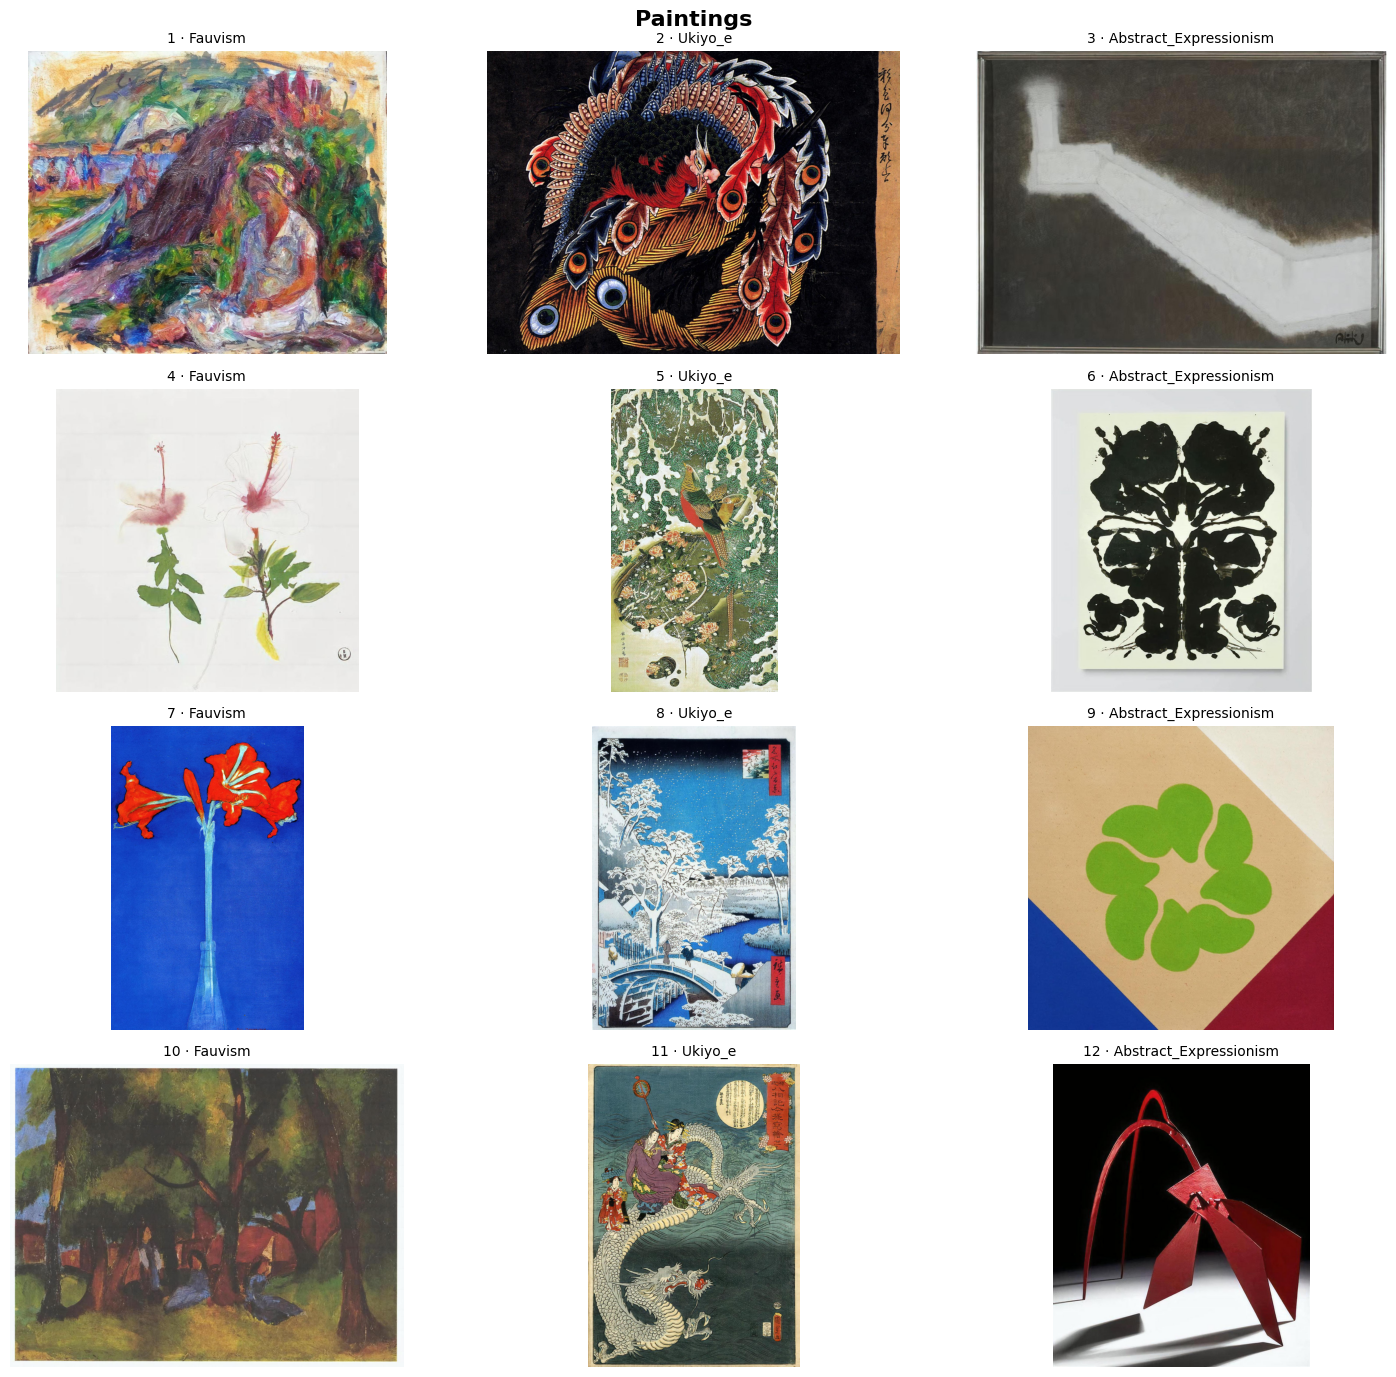

In [8]:
WORKING_DIR_PATH = Path.cwd()
IMAGES_DIR_PATH = WORKING_DIR_PATH / "images"

loader = ImageLoader()
loader.plot_images()

In [9]:
class ScoreTracker:

    def __init__(self):
        
        self.scores = pd.DataFrame(columns = ['Model', 'Style', 'Author', 'Silhouette Score', 'n_Clusters', 'Path', 'Time'])

    def update(self, model_name: str,  image_record: list, best_score: float, best_k: int, image_path: Path, time: float):
        self.scores.loc[len(self.scores)] = {
            'Model' : model_name,
            'Style' : image_record[1],
            'Author' : image_path.stem.split(r'_')[0],
            'Silhouette Score' : best_score,
            'n_Clusters' : best_k,
            'Path' : image_path,
            'Time' : time,
        } 

In [10]:
extractor = FeatureExtractor()

groupers = {'KMeans' : ColorGrouper(min_k=3,
                                    max_k=20,
                                    random_state=42),
            'DBSCAN' : DBSCANGrouper(
                train_cap=50_000,
                random_state=42,
                eps_grid=[0.03, 0.05, 0.08],
                min_samples_grid=[50, 100],
                eval_sample_cap=5_000),
            "MeanShift": MeanShiftGrouper(
                train_cap=50_000,
                random_state=42,
                quantiles=[0.1, 0.2, 0.3],
                bw_n_samples=2_000,
                eval_sample_cap=5_000)
           }



reporter = PaletteReporter(max_points=5000)
score_tracker = ScoreTracker()

for i, img_path in enumerate(loader.image_files):
    pixels = extractor.extract(img_path)
    for algorithm, grouper in groupers.items():

        t0 = time.perf_counter()
        best_model, best_score, k_scores = grouper.find_best_grouping(pixels)
        t1 = time.perf_counter()
        elapsed = t1-t0

        has_centers = (
            best_model is not None and
            hasattr(best_model, "cluster_centers_") and
            getattr(best_model, "cluster_centers_", None) is not None and
            len(getattr(best_model, "cluster_centers_", [])) >= 2
        )
    
        if has_centers and k_scores:
            score_tracker.update(
                model_name=algorithm,
                image_record=loader.image_records[i],
                best_score=best_score,
                best_k = max(k_scores, key=k_scores.get),
                image_path=img_path,
                time = elapsed,
            )
            if best_score > 0:
                reporter.plot_analysis(
                    image_path=img_path,
                    model=best_model,
                    pixel_data=pixels,
                    k_scores=k_scores,
                    save=True,
                    out_dir=Path("reports"),  
                    dpi=160,
                    show=False,                # False to NOT display
                    transparent=False,
                    algorithm=algorithm
                )

            else:
                continue
        else:
            # debugger
            print(f"[INFO] Skipping plot for {img_path.name} ({algorithm}): model={type(best_model).__name__ if best_model else None}, centers={getattr(best_model, 'cluster_centers_', None)}")
                


[INFO] Saved analysis to: reports/abraham-manievich_artist-s-wife-1937__KMeans__analysis.png
[INFO] Saved analysis to: reports/abraham-manievich_artist-s-wife-1937__DBSCAN__analysis.png
[INFO] Saved analysis to: reports/abraham-manievich_artist-s-wife-1937__MeanShift__analysis.png
[INFO] Saved analysis to: reports/katsushika-hokusai_ceiling-of-ganshoin-temple-at-obuse__KMeans__analysis.png
[INFO] Saved analysis to: reports/katsushika-hokusai_ceiling-of-ganshoin-temple-at-obuse__DBSCAN__analysis.png
[INFO] Saved analysis to: reports/katsushika-hokusai_ceiling-of-ganshoin-temple-at-obuse__MeanShift__analysis.png
[INFO] Saved analysis to: reports/abidin-dino_antibes-1961-1__KMeans__analysis.png
[INFO] Saved analysis to: reports/abidin-dino_antibes-1961-1__DBSCAN__analysis.png
[INFO] Saved analysis to: reports/abidin-dino_antibes-1961-1__MeanShift__analysis.png
[INFO] Saved analysis to: reports/brett-whiteley_hibiscus-1987__KMeans__analysis.png
[INFO] Saved analysis to: reports/brett-white

In [11]:
score_tracker.scores.head()

Model    Style              Author  Silhouette Score  n_Clusters  \
0     KMeans  Fauvism   abraham-manievich          0.414602           3   
1     DBSCAN  Fauvism   abraham-manievich          0.250158           7   
2  MeanShift  Fauvism   abraham-manievich          0.491420           2   
3     KMeans  Ukiyo_e  katsushika-hokusai          0.636790           3   
4     DBSCAN  Ukiyo_e  katsushika-hokusai          0.602818           4   

                                                Path       Time  
0  /Users/castellano/Documents/UniAndes/Ciclo3/Un...   9.959388  
1  /Users/castellano/Documents/UniAndes/Ciclo3/Un...   5.245815  
2  /Users/castellano/Documents/UniAndes/Ciclo3/Un...   6.193994  
3  /Users/castellano/Documents/UniAndes/Ciclo3/Un...   9.607537  
4  /Users/castellano/Documents/UniAndes/Ciclo3/Un...  26.620176

In [12]:
score_tracker.scores.groupby(by=['Style','Model'])['Silhouette Score'].describe()

count      mean       std       min  \
Style                  Model                                            
Abstract_Expressionism DBSCAN       4.0  0.845004  0.075665  0.769375   
                       KMeans       4.0  0.830599  0.055322  0.777519   
                       MeanShift    4.0  0.825183  0.062591  0.756057   
Fauvism                DBSCAN       4.0  0.711696  0.311226  0.250158   
                       KMeans       4.0  0.684388  0.222596  0.414602   
                       MeanShift    4.0  0.679944  0.178543  0.491420   
Ukiyo_e                DBSCAN       4.0  0.420748  0.155767  0.226235   
                       KMeans       4.0  0.566747  0.059156  0.512068   
                       MeanShift    4.0  0.633322  0.051930  0.578921   

                                       25%       50%       75%       max  
Style                  Model                                              
Abstract_Expressionism DBSCAN     0.785406  0.847236  0.906834  0.916168  
                       KMeans     0.794661  0.820577  0.856515  0.903723  
                       MeanShift  0.789734  0.820476  0.855924  0.903723  
Fauvism                DBSCAN     0.672180  0.835061  0.874578  0.926506  
                       KMeans     0.548703  0.711390  0.847075  0.900170  
                       MeanShift  0.546265  0.689636  0.823316  0.849083  
Ukiyo_e                DBSCAN     0.354738  0.426970  0.492980  0.602818  
                       KMeans     0.520881  0.559065  0.604930  0.636790  
                       MeanShift  0.599973  0.628202  0.661551  0.697962

## 7. Análisis de Silhouette Scores

Los resultados evidencian una interacción significativa entre el estilo artístico y el mecanismo de agrupamiento de cada algoritmo, lo que confirma que la estructura cromática de las imágenes influye directamente en el desempeño del clustering. Esta relación puede explicarse a partir de los supuestos geométricos y estadísticos que cada método impone sobre los datos.

### Expresionismo Abstracto

El alto rendimiento observado en los tres algoritmos se explica por la naturaleza del Expresionismo Abstracto, caracterizado por grandes campos de color, contrastes intensos y separaciones claras en el espacio cromático.

- K-Means, al asumir clústeres aproximadamente esféricos y bien separados, funciona eficazmente cuando los colores dominantes forman agrupaciones compactas alrededor de centroides claros.

- Mean Shift, al identificar modos en la densidad de color, se beneficia de regiones cromáticas extensas y coherentes.

- DBSCAN obtiene el mejor desempeño promedio porque detecta regiones densas de color sin imponer una forma específica, lo que resulta ideal para distribuciones irregulares y expresivas típicas de este estilo.

### Fauvismo

En el Fauvismo, los colores son saturados y expresivos, pero su distribución espacial y densidad cromática es menos homogénea.

- DBSCAN alcanza valores máximos elevados cuando los colores forman regiones densas bien definidas; sin embargo, su alta desviación estándar refleja su sensibilidad a los hiperparámetros (eps y min_samples) en escenarios donde la densidad varía entre colores.

- K-Means muestra un desempeño más estable al forzar particiones globales alrededor de centroides, lo que reduce la varianza entre ejecuciones, aunque puede mezclar colores cuando las fronteras no son claramente convexas.

- Mean Shift se ve afectado por la elección del bandwidth, ya que diferentes escalas de densidad cromática conducen a distintos números de modos detectados.

### Ukiyo-e

El comportamiento observado en Ukiyo-e se explica por su uso de paletas restringidas, áreas de color planas y transiciones abruptas, con baja variabilidad interna.

- DBSCAN presenta un bajo desempeño promedio porque la densidad de los píxeles es alta dentro de cada color, pero la separación entre colores no siempre cumple con los criterios de densidad continua que el algoritmo requiere, provocando la fusión de clústeres o la clasificación excesiva como ruido.

- K-Means, al imponer un número fijo de clústeres, logra particionar adecuadamente estos colores discretos, siempre que el valor de k sea razonable.

- Mean Shift obtiene el mejor desempeño al identificar directamente los modos discretos en la distribución cromática, lo que se alinea naturalmente con la estructura repetitiva y controlada del Ukiyo-e.




In [13]:
score_tracker.scores.groupby(by=['Style','Model'])['Time'].describe()

count       mean        std        min  \
Style                  Model                                               
Abstract_Expressionism DBSCAN       4.0  30.843117   5.067201  25.017206   
                       KMeans       4.0   7.964130   0.533095   7.419545   
                       MeanShift    4.0   2.098709   0.724815   1.135753   
Fauvism                DBSCAN       4.0  50.800422  51.637103   5.245815   
                       KMeans       4.0   9.274629   0.582926   8.603218   
                       MeanShift    4.0   3.897145   1.626841   2.472696   
Ukiyo_e                DBSCAN       4.0  14.758170   7.940186   9.794441   
                       KMeans       4.0   9.239578   0.374746   8.757351   
                       MeanShift    4.0   3.013418   0.331731   2.732531   

                                        25%        50%        75%         max  
Style                  Model                                                   
Abstract_Expressionism DBSCAN     27.408350  31.441974  34.876741   35.471316  
                       KMeans      7.683560   7.876343   8.156912    8.684289  
                       MeanShift   1.846266   2.189880   2.442324    2.879324  
Fauvism                DBSCAN     20.137168  37.308468  67.971723  123.338938  
                       KMeans      8.934375   9.267955   9.608210    9.959388  
                       MeanShift   2.946224   3.460946   4.411867    6.193994  
Ukiyo_e                DBSCAN     10.915704  11.309031  15.151496   26.620176  
                       KMeans      9.047096   9.296712   9.489194    9.607537  
                       MeanShift   2.755639   2.943873   3.201651    3.433397

## 8. Análisis de Tiempos de Ejecución 

La tabla de estadísticas descriptivas de tiempo revela diferencias consistentes y explicables entre los algoritmos de clustering y los estilos artísticos analizados (Abstract Expressionism, Fauvism y Ukiyo-e).

**DBSCAN** presenta, de forma sistemática, los **tiempos de ejecución más altos y con mayor variabilidad** en todos los estilos. Esto es especialmente evidente en *Fauvism*, donde el tiempo medio supera los 50 segundos y el máximo alcanza más de 125 segundos. Este comportamiento se explica porque DBSCAN depende de búsquedas de vecinos en el espacio de características; cuando la distribución de colores es densa, variada o presenta múltiples regiones de distinta densidad (como ocurre en Fauvism), el costo computacional aumenta significativamente y se vuelve más sensible a la estructura interna de los datos.

**K-Means** muestra los **tiempos más estables y predecibles** en todos los estilos, con medias cercanas a los 8–9 segundos y desviaciones estándar muy bajas. Esto refleja su complejidad computacional relativamente controlada, dominada por iteraciones lineales sobre los datos y el número de clústeres. La consistencia de los tiempos sugiere que, independientemente del estilo pictórico, el tamaño del conjunto de píxeles y el rango de k evaluado dominan el costo más que la estructura cromática en sí.

**Mean Shift** es el algoritmo **más rápido en promedio**, con tiempos inferiores a los 4 segundos en todos los estilos. Sin embargo, esta eficiencia viene acompañada de una simplificación implícita: el algoritmo converge rápidamente cuando la estimación de densidad encuentra modos claros, lo que ocurre con frecuencia en espacios de color donde existen regiones cromáticas bien definidas. En estilos como Ukiyo-e, con paletas más contenidas y menos ruido cromático, Mean Shift resulta especialmente eficiente y estable.

En conjunto, estos resultados muestran un claro **trade-off entre expresividad del modelo y costo computacional**. DBSCAN ofrece una segmentación sensible a la estructura de densidad pero a un alto costo temporal; K-Means proporciona un equilibrio robusto entre calidad y eficiencia; y Mean Shift prioriza velocidad y detección de modos, siendo ideal cuando se busca una extracción rápida de paletas sin explorar exhaustivamente la estructura del espacio de color.


In [14]:
score_tracker.scores.sort_values(by="Silhouette Score",ascending=False).head(10)

Model                   Style          Author  Silhouette Score  \
10     DBSCAN                 Fauvism  brett-whiteley          0.926506   
16     DBSCAN  Abstract_Expressionism     andy-warhol          0.916168   
26  MeanShift  Abstract_Expressionism       paul-reed          0.903723   
25     DBSCAN  Abstract_Expressionism       paul-reed          0.903723   
24     KMeans  Abstract_Expressionism       paul-reed          0.903723   
9      KMeans                 Fauvism  brett-whiteley          0.900170   
19     DBSCAN                 Fauvism   piet-mondrian          0.857268   
11  MeanShift                 Fauvism  brett-whiteley          0.849083   
15     KMeans  Abstract_Expressionism     andy-warhol          0.840779   
8   MeanShift  Abstract_Expressionism     abidin-dino          0.839992   

    n_Clusters                                               Path        Time  
10           2  /Users/castellano/Documents/UniAndes/Ciclo3/Un...  123.338938  
16           2  /Users/castellano/Documents/UniAndes/Ciclo3/Un...   25.017206  
26           5  /Users/castellano/Documents/UniAndes/Ciclo3/Un...    1.135753  
25           5  /Users/castellano/Documents/UniAndes/Ciclo3/Un...   28.205398  
24           5  /Users/castellano/Documents/UniAndes/Ciclo3/Un...    7.419545  
9            3  /Users/castellano/Documents/UniAndes/Ciclo3/Un...    9.491151  
19           2  /Users/castellano/Documents/UniAndes/Ciclo3/Un...   49.515985  
11          15  /Users/castellano/Documents/UniAndes/Ciclo3/Un...    3.817824  
15           3  /Users/castellano/Documents/UniAndes/Ciclo3/Un...    7.771565  
8            2  /Users/castellano/Documents/UniAndes/Ciclo3/Un...    2.083103

## 9. Análisis de Ejemplos

In [15]:
def show_three_reports(report_paths):

    if len(report_paths) != 3:
        raise ValueError("Pass exactly 3 report image paths")

    fig, axs = plt.subplots(3, 1, figsize=(22, 15))

    for ax, path in zip(axs, report_paths):
        path = Path(path)
        with Image.open(path) as img:
            ax.imshow(img)
        ax.set_title(path.name, fontsize=10)
        ax.axis("off")

    plt.tight_layout()
    plt.show()

In [16]:
hibiscus = ['reports/brett-whiteley_hibiscus-1987__KMeans__analysis.png',
            'reports/brett-whiteley_hibiscus-1987__DBSCAN__analysis.png',
            'reports/brett-whiteley_hibiscus-1987__MeanShift__analysis.png',
           ]
wife = ['reports/abraham-manievich_artist-s-wife-1937__KMeans__analysis.png',
        'reports/abraham-manievich_artist-s-wife-1937__DBSCAN__analysis.png',
        'reports/abraham-manievich_artist-s-wife-1937__MeanShift__analysis.png',
       ]

_12 = ['reports/paul-reed_12-1964__KMeans__analysis.png',
        'reports/paul-reed_12-1964__DBSCAN__analysis.png',
        'reports/paul-reed_12-1964__MeanShift__analysis.png',
       ]
dragon = ['reports/utagawa-kunisada-ii_the-dragon__KMeans__analysis.png',
        'reports/utagawa-kunisada-ii_the-dragon__DBSCAN__analysis.png',
        'reports/utagawa-kunisada-ii_the-dragon__MeanShift__analysis.png',
       ]

### **Brett Whiteley – *Hibiscus* (1987)** (Poca variabilidad cromatica)

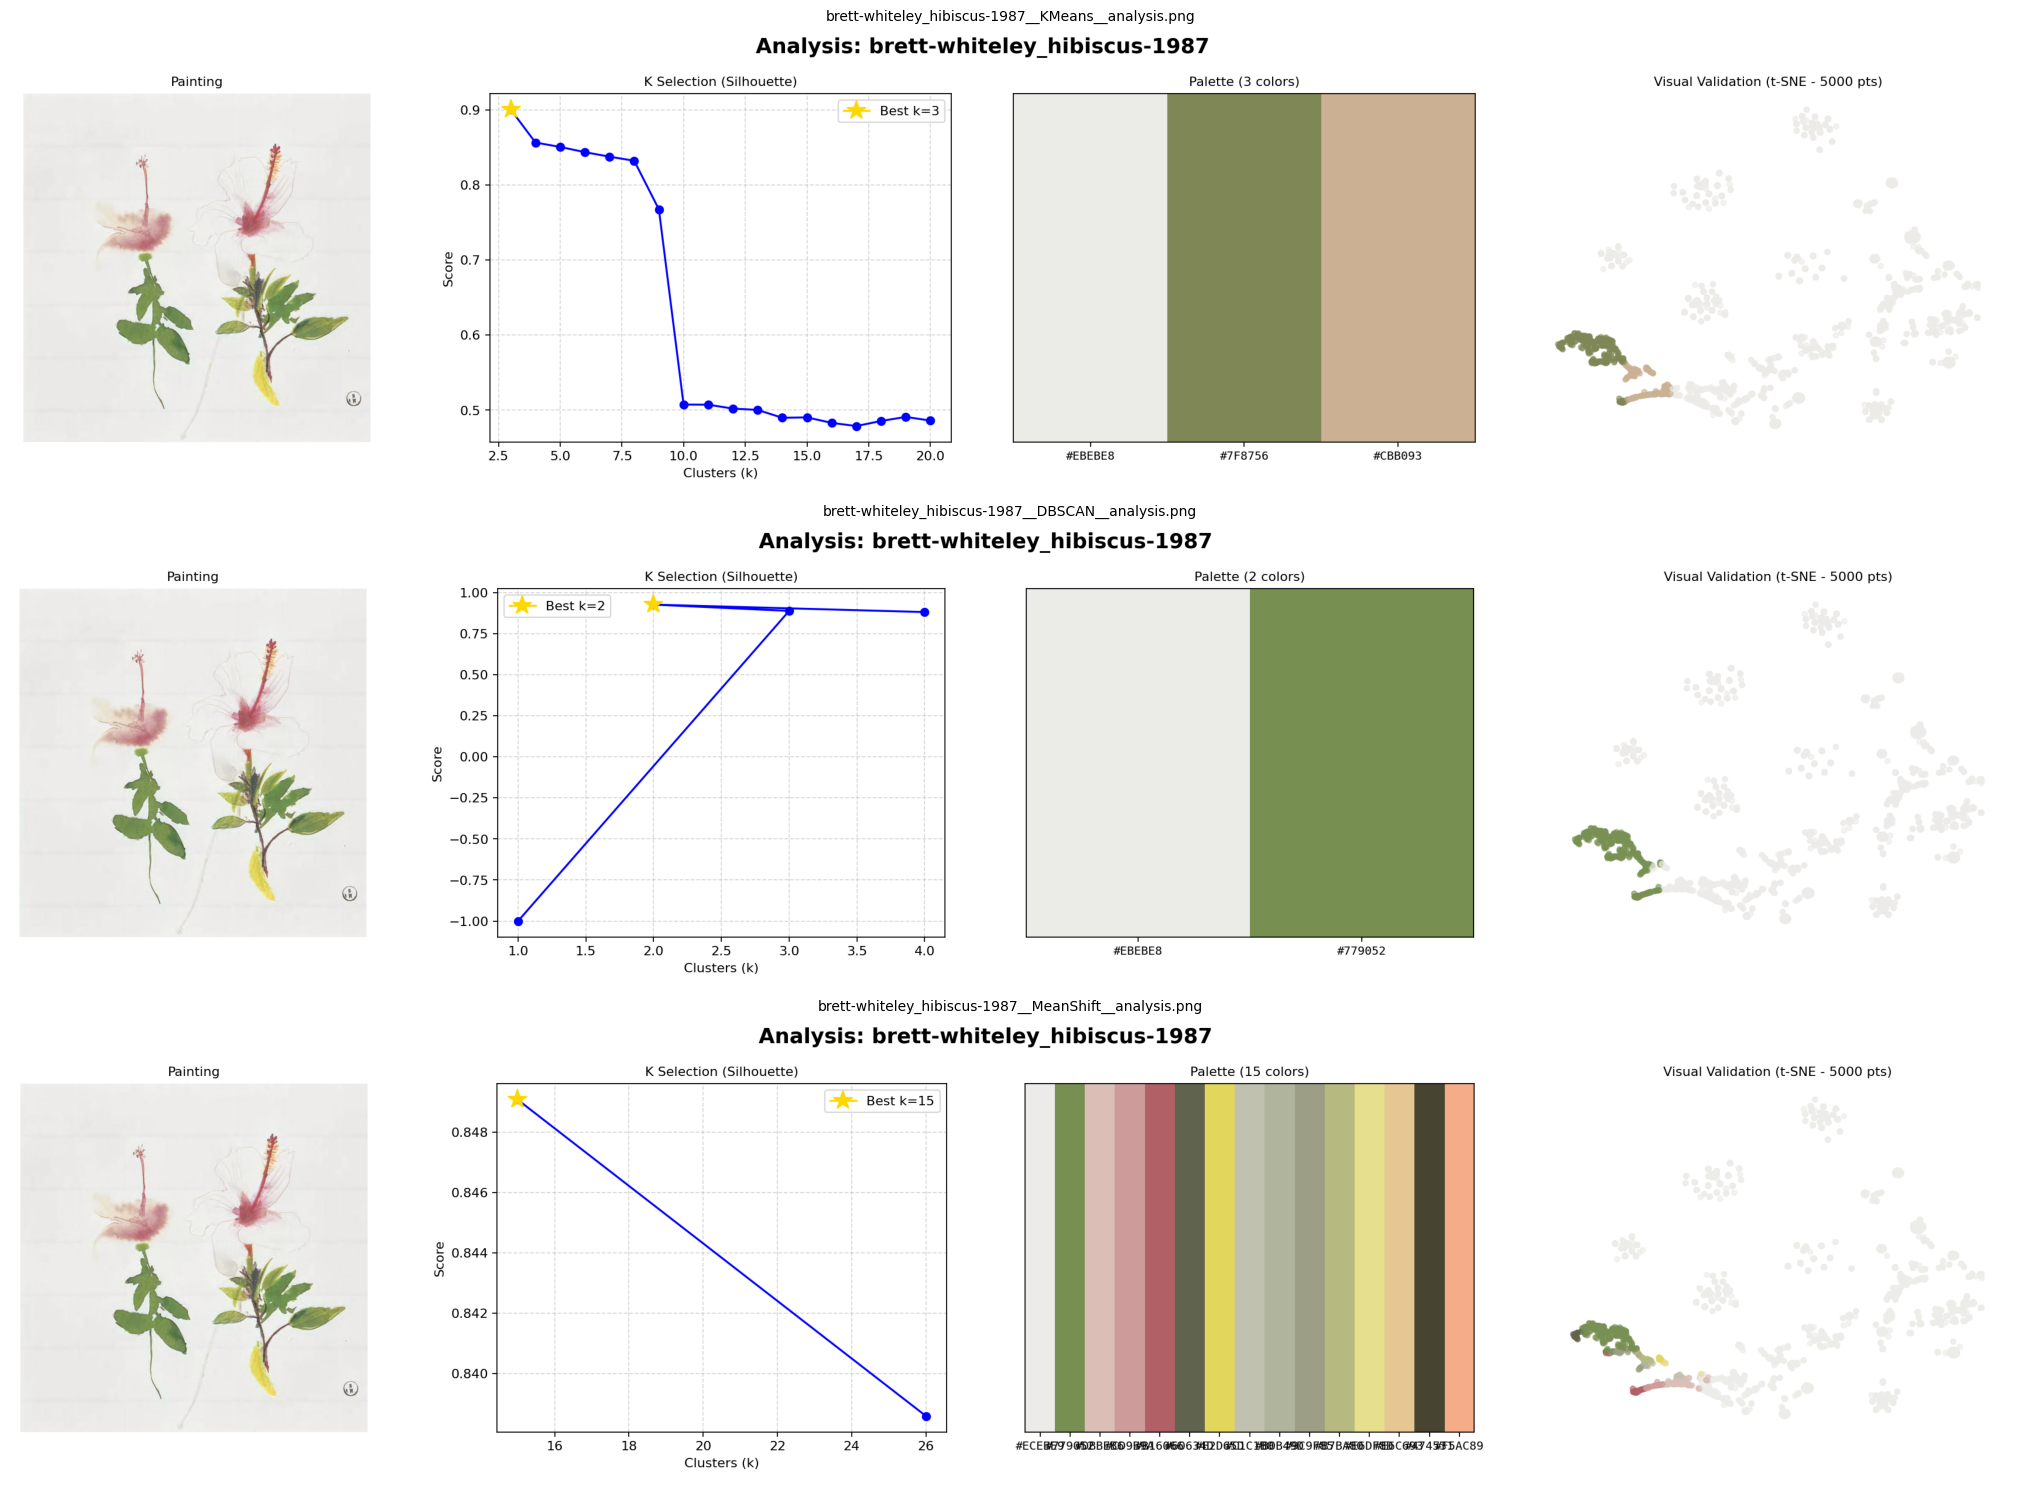

In [17]:
show_three_reports(hibiscus)# Análisis de Clustering Cromático  

La obra se caracteriza por un fondo muy claro, grandes áreas de espacio negativo y acentos cromáticos concentrados (verdes y rosados), lo que genera una estructura de color altamente desequilibrada.


#### K-Means (k óptimo = 3)

- Esto ocurre porque **K-Means fuerza particiones convexas alrededor de centroides**, optimizando distancia euclídea.
- En *Hibiscus*, el espacio de color se organiza naturalmente en:
  1. fondo claro,
  2. verdes dominantes,
  3. tonos florales suaves.


Cuando k > 3, K-Means empieza a **dividir artificialmente regiones cromáticamente homogéneas**, lo que reduce la cohesión interna de los clusters y explica la caída del Silhouette. El algoritmo funciona bien mientras los clusters coinciden con **modos globales del color**, pero penaliza la sobresegmentación.

#### DBSCAN (clusters efectivos = 2)

- El Silhouette es alto porque los dos grupos están **muy bien separados en densidad**:
  - píxeles claros del fondo,
  - píxeles verdes (y algunos florales) más densos.

DBSCAN no busca centroides ni un número fijo de clusters, sino **regiones de alta densidad** separadas por zonas de baja densidad. En esta pintura, los tonos florales son escasos en comparación con fondo y hojas, por lo que:
- no forman un cluster suficientemente denso,
- quedan absorbidos por el grupo más cercano o ruido

Esto explica por qué DBSCAN produce una segmentación **coarse pero muy estable**, alineada con la estructura estadística del color, aunque menos rica semánticamente.

#### Mean Shift (k óptimo ≈ 15)

- Mean Shift alcanza su mejor Silhouette con un **número alto de clusters**.
- La paleta resultante es mucho más detallada, capturando:
  - variaciones de verdes,
  - matices rosados,
  - ligeros cambios tonales del fondo.

Mean Shift estima **modos locales del espacio de color** mediante ventanas de densidad (bandwidth). En una imagen con **gradientes suaves y transiciones continuas**, como *Hibiscus*, esto provoca:
- la aparición de múltiples máximos locales,
- una fragmentación natural del color en muchos clusters coherentes.

El descenso gradual del Silhouette al aumentar k indica que el algoritmo sigue encontrando estructura real, pero cada nuevo cluster aporta **menos separación global**.


#### Conclusión

- **K-Means** refleja su sesgo hacia pocos centroides globales, funcionando mejor cuando la imagen tiene **colores dominantes bien separados**.
- **DBSCAN** traduce directamente la **distribución de densidades**, privilegiando estabilidad sobre riqueza cromática.
- **Mean Shift** expone la **microestructura del color**, capturando gradientes y variaciones sutiles a costa de complejidad.


### **Abraham Manievich – *Artist’s Wife* (1937)** (Alta variabilidad cromatica)


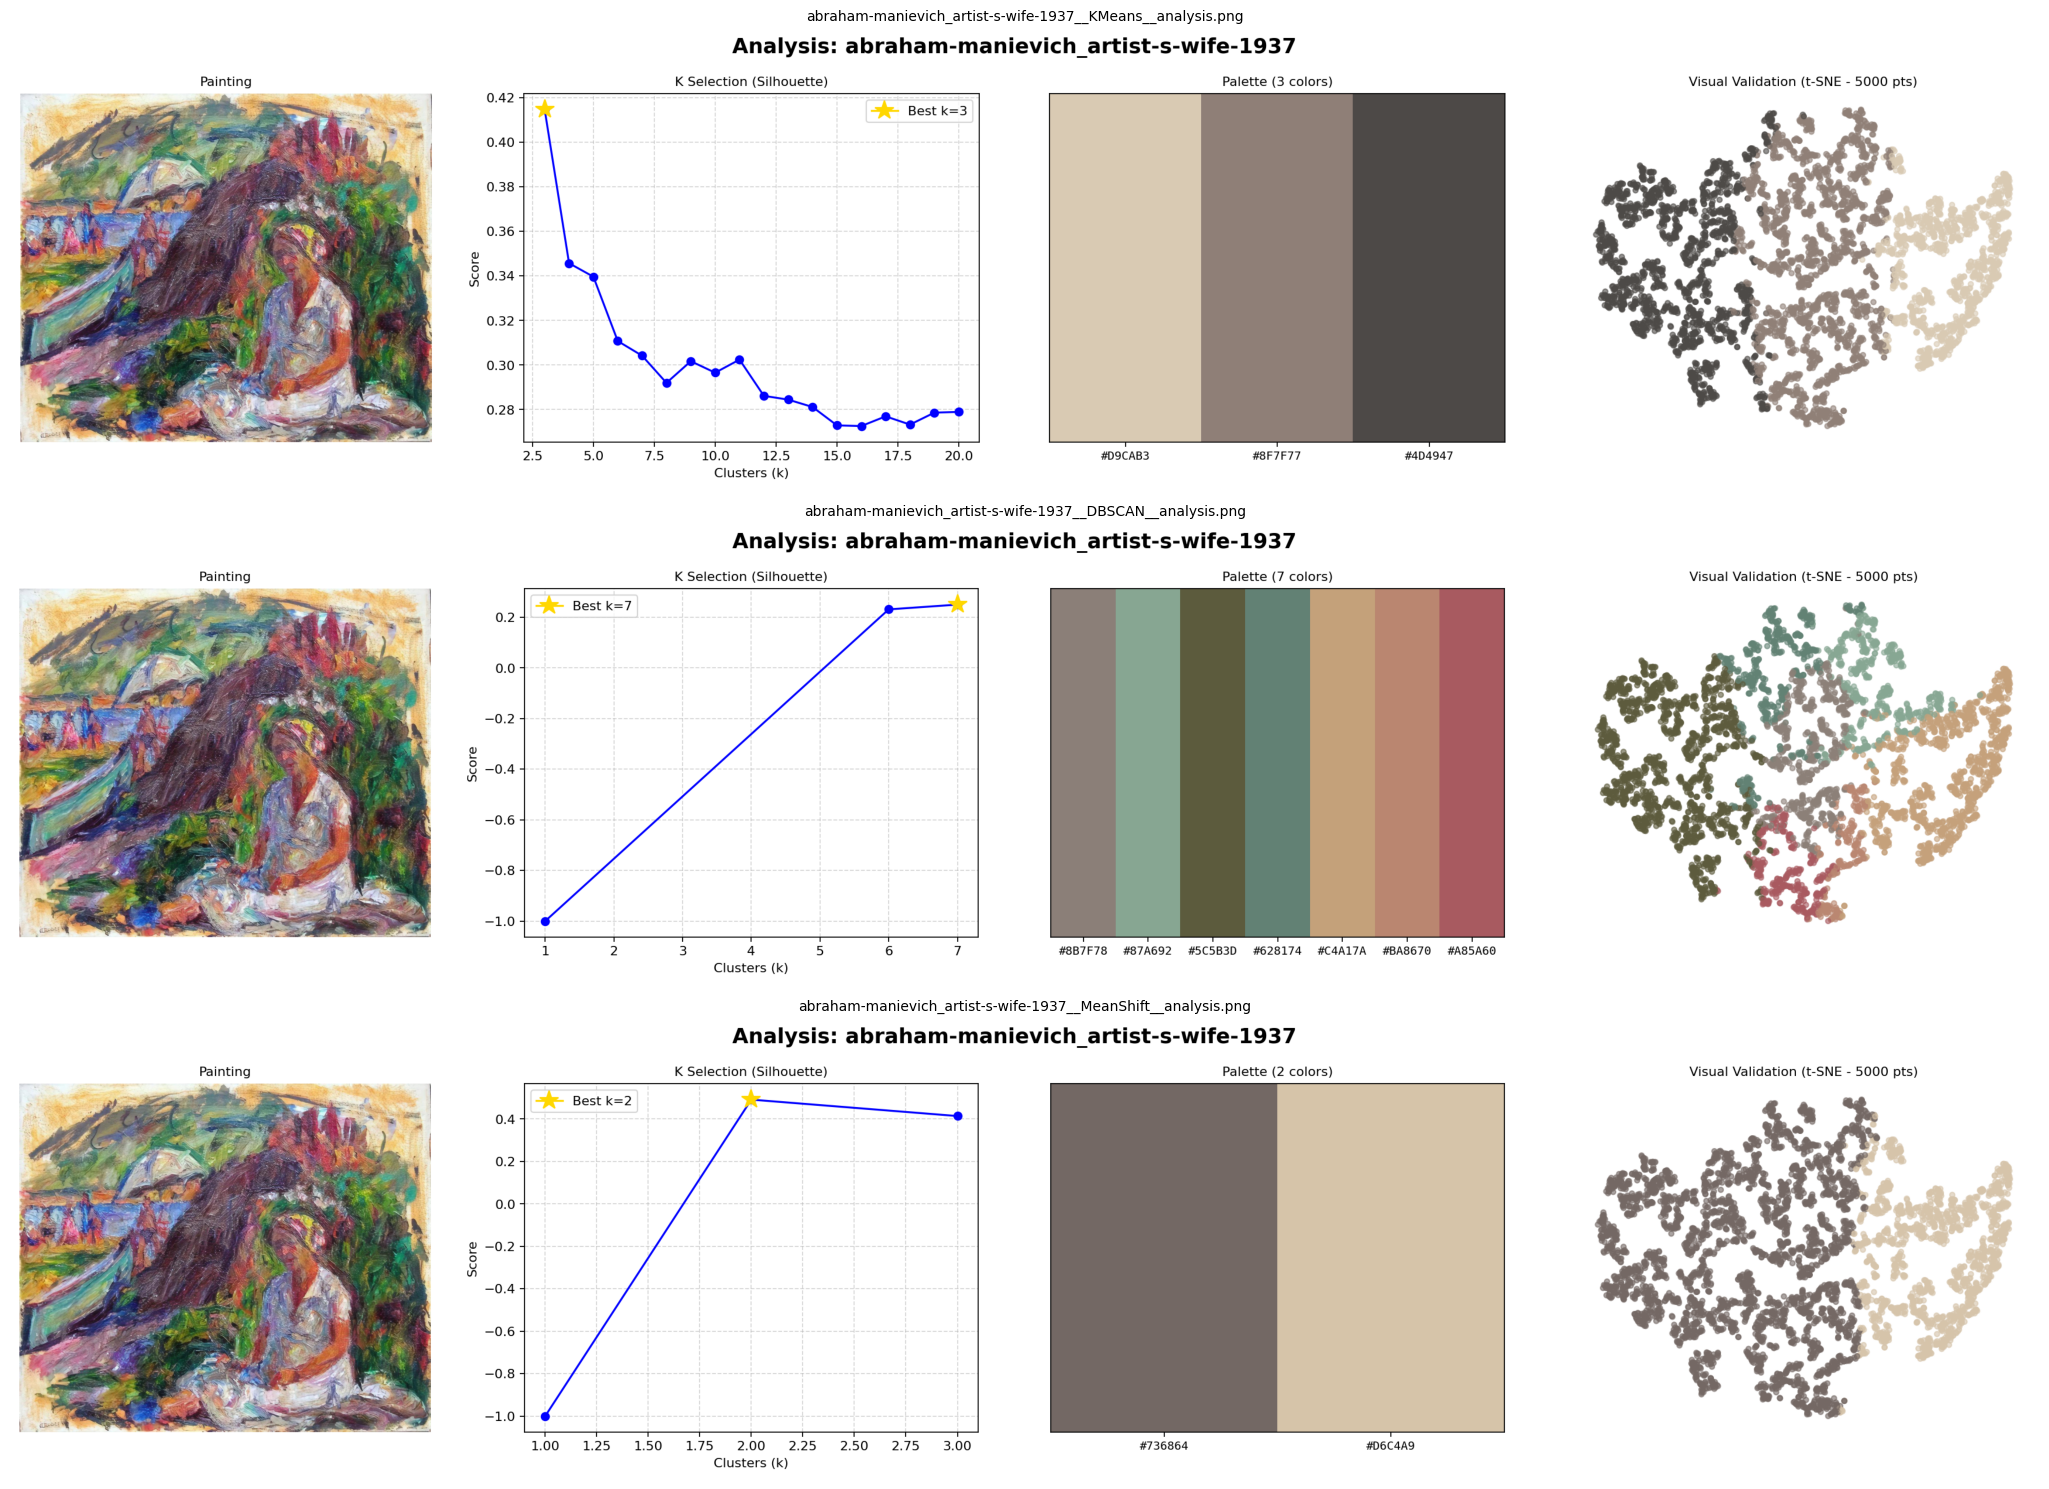

In [18]:
show_three_reports(wife)


La obra presenta alta variabilidad cromática y transiciones suaves

#### K-Means (k óptimo = 3)

- Indica que el espacio de color se segmenta mejor en **pocas masas cromáticas grandes**.
- La paleta captura:
  - tonos claros (fondo/luz),
  - tonos medios terrosos,
  - tonos oscuros estructurales.
- En **t-SNE**, los clusters son distinguibles pero con **bordes difusos**, lo que explica un Silhouette moderado (~0.42).

**Interpretación**  
K-Means impone fronteras lineales y funciona bien para resumir la imagen en grandes regiones, pero no sigue bien la complejidad local de las pinceladas.

#### DBSCAN (≈ 7 clusters)

- El Silhouette mejora al aumentar el número de clusters detectados.
- Detecta **regiones de densidad cromática** sin fijar *k*.
- La paleta es más rica y coherente con la expresividad del cuadro:
  verdes apagados, ocres, rosados, azules sucios y marrones profundos.
- En **t-SNE**, los clusters son **no convexos** y localmente coherentes.

**Interpretación**  
DBSCAN captura mejor la heterogeneidad cromática y la gestualidad pictórica, a costa de mayor complejidad computacional y sensibilidad a parámetros.


#### Mean Shift (k óptimo = 2)

- Identifica **dos modos dominantes** del espacio de color.
- La paleta separa principalmente:
  - tonos claros,
  - tonos oscuros.
- En **t-SNE**, la separación es clara pero **excesivamente binaria**.

**Interpretación**  
Mean Shift prioriza eficiencia y simplicidad, pero sub-representa la riqueza cromática de la obra.



#### Conclusiones

- **K-Means**: abstracción estable y legible; adecuado para resúmenes cromáticos.
- **DBSCAN**: mejor fidelidad artística; refleja la complejidad expresiva.
- **Mean Shift**: rápido y simple; pierde detalle cromático.


### **Paul Reed – *12-1964*** (Buen rendimiento, diferentes mecanicas)


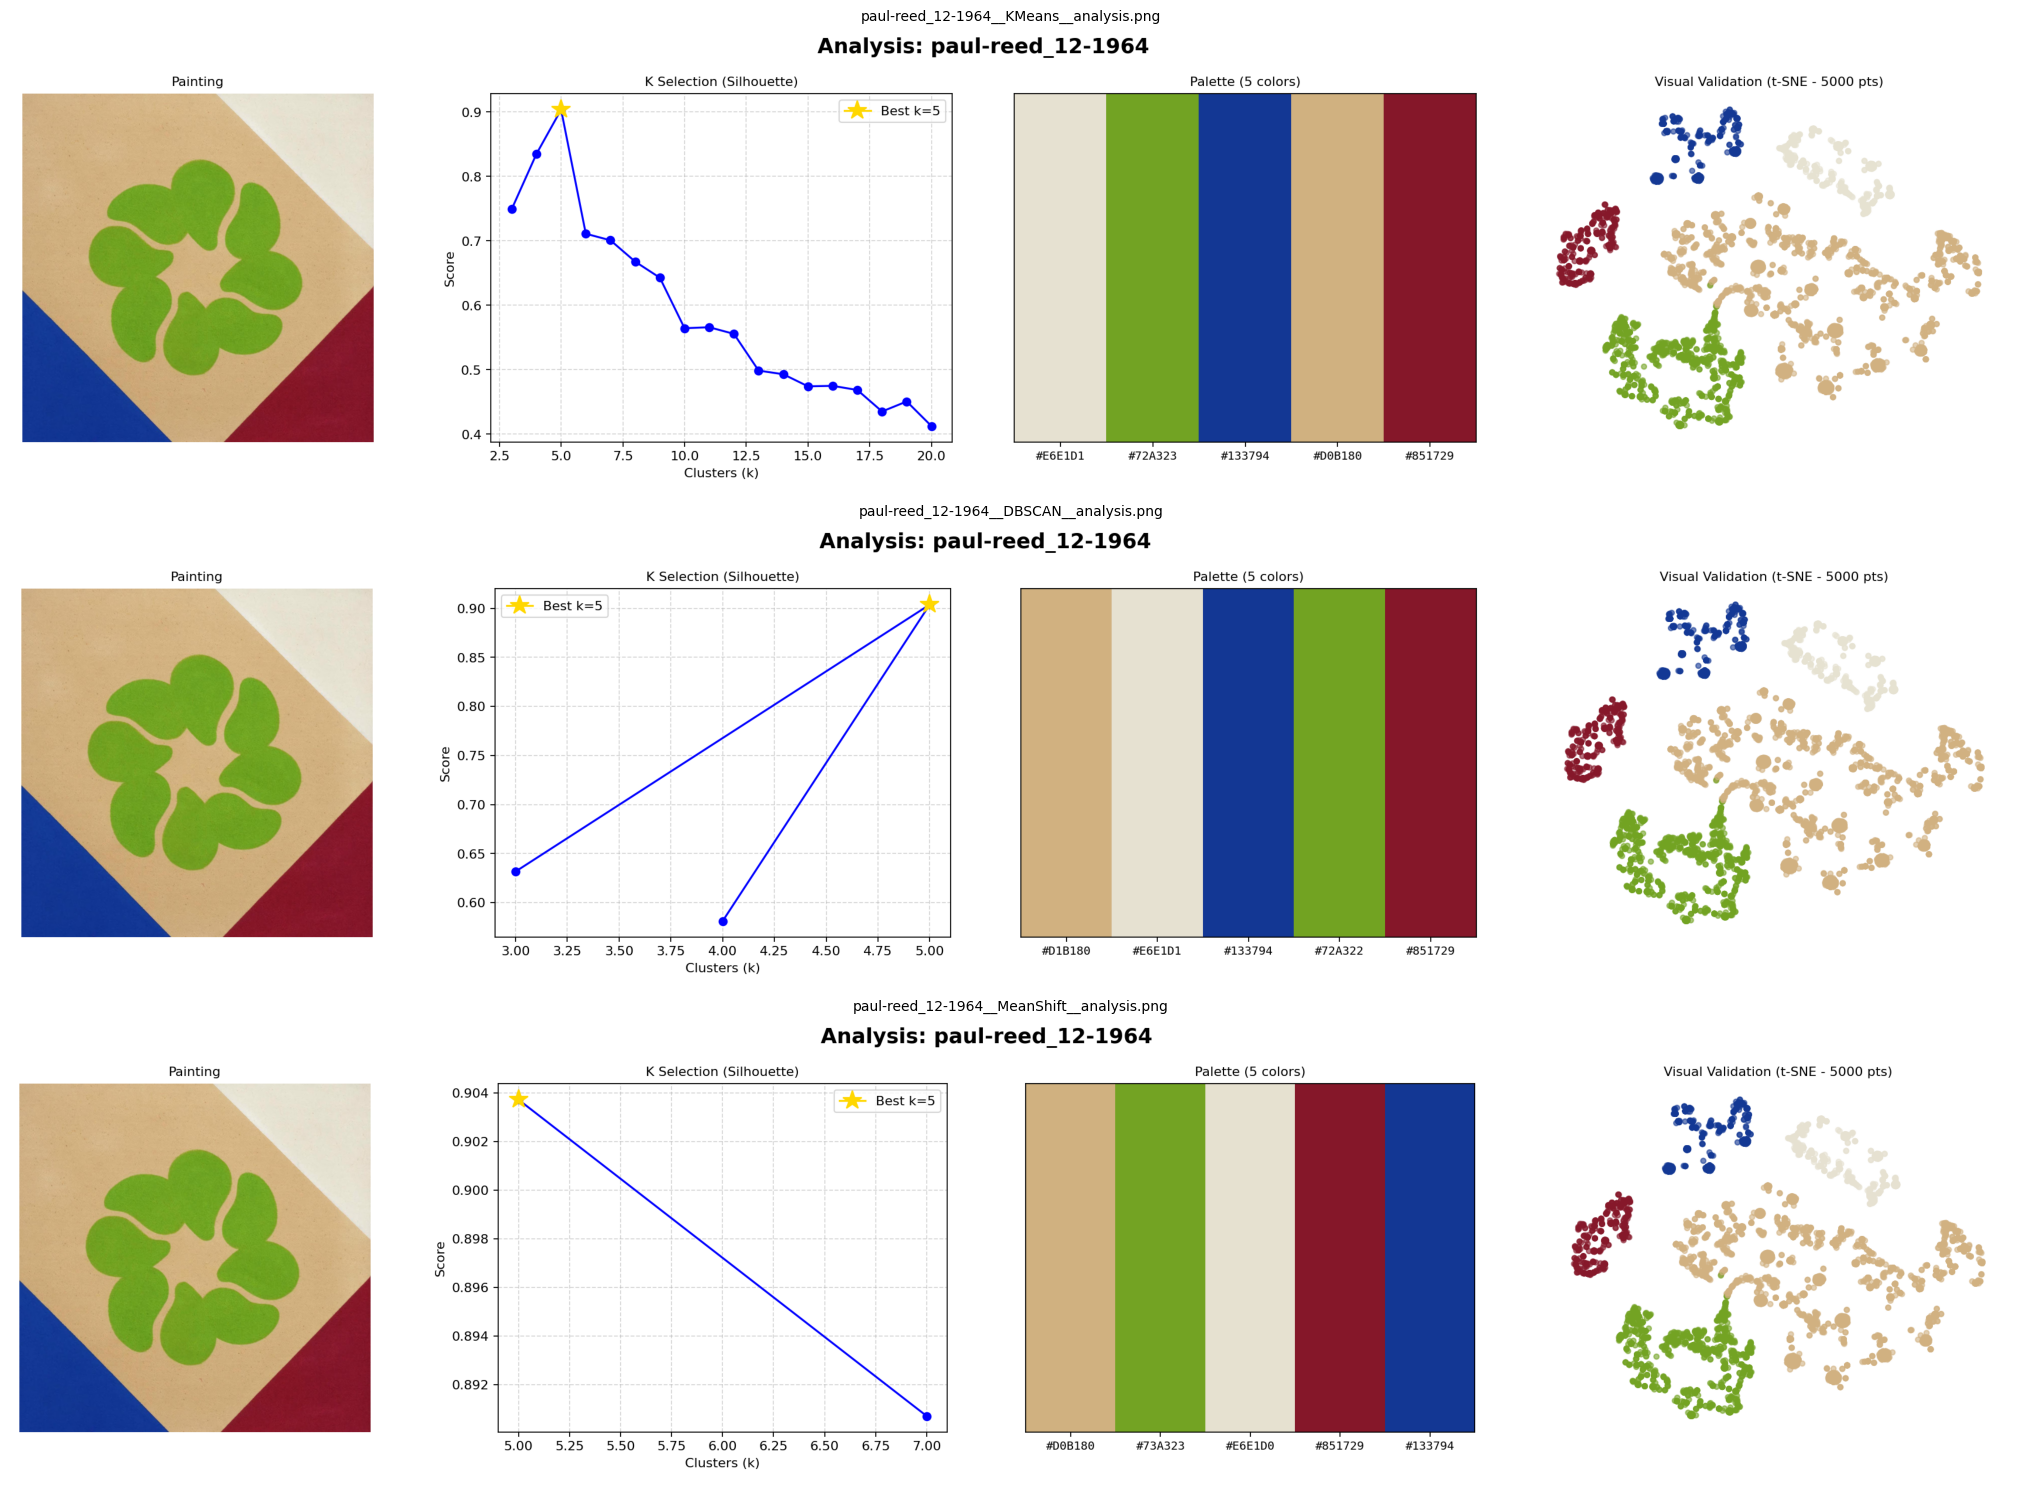

In [19]:
show_three_reports(_12)


Esta obra presenta **regiones geométricas bien definidas**, colores planos y transiciones abruptas, lo que constituye un caso ideal para algoritmos de clustering en el espacio RGB/Lab. Se comparan **K-Means**, **DBSCAN** y **Mean Shift** usando Silhouette score, paletas extraídas y validación visual con t-SNE.

#### K-Means (k óptimo ≈ 6–7)

- El **máximo Silhouette se alcanza con un k intermedio**, superior al observado en *Hibiscus*.
- Esto se debe a que el espacio cromático está organizado en **varios modos globales bien separados**, correspondientes a los grandes bloques de color.

K-Means optimiza particiones convexas alrededor de centroides. En la obra de Paul Reed, los colores:
- son homogéneos dentro de cada región,
- están bien separados en el espacio RGB.

Esto permite que cada bloque cromático sea representado por un centroide estable. Cuando k coincide con el número real de campos de color dominantes, el Silhouette es alto. Al aumentar k más allá de este punto, el algoritmo comienza a **fragmentar regiones perfectamente uniformes**, introduciendo divisiones artificiales que reducen la cohesión y explican la caída del Silhouette.


#### DBSCAN (clusters efectivos ≈ 3–4)

- DBSCAN identifica un **número reducido de clusters densos**, inferior al de K-Means.
- Los clusters corresponden a los **colores más extensos y frecuentes** en la pintura.

DBSCAN agrupa píxeles en función de **densidad local** y trata como ruido las regiones poco pobladas. En esta obra:
- los colores principales forman **núcleos densos muy claros**,
- colores secundarios o de menor área pueden no alcanzar la densidad mínima requerida.

Como resultado, DBSCAN produce una segmentación **robusta y geométricamente coherente**, pero tiende a **fusionar o descartar colores minoritarios**, reflejando su preferencia por estructura estadística fuerte frente a riqueza cromática.


#### Mean Shift (k óptimo ≈ 10–15)


- La paleta resultante captura:
  - subdivisiones dentro de un mismo bloque de color,
  - ligeras variaciones de saturación o iluminación.

Mean Shift busca **máximos locales de densidad** en el espacio de color. Aunque la obra presenta colores planos, pequeñas variaciones introducidas por:
- textura del lienzo,
- iluminación,
- digitalización de la imagen,

generan múltiples modos cercanos. El algoritmo interpreta estas variaciones como estructura real, produciendo una **sobresegmentación controlada**. El Silhouette decrece lentamente, indicando que, aunque los clusters adicionales son coherentes localmente, aportan menor separación global.


#### Conclusión 

- **K-Means** se alinea bien con la **geometría explícita** de la obra, capturando campos de color dominantes de forma eficiente.
- **DBSCAN** traduce la pintura a su **estructura de densidades**, priorizando colores mayoritarios y descartando detalles.
- **Mean Shift** revela la **microvariabilidad cromática**, incluso en superficies aparentemente uniformes.

En la obra de **Paul Reed**, la claridad geométrica y la saturación cromática hacen que las **hipótesis internas de cada algoritmo se manifiesten con especial nitidez**, mostrando cómo los enfoques basados en centroides, densidad y estimación modal interpretan de forma distinta una misma estructura visual.


### **Utagawa Kunisada II – *The Dragon*** (Caso limite)

Esta obra del **Ukiyo-e** se caracteriza por **contornos bien definidos, áreas de color planas y una paleta limitada pero jerárquica**, donde conviven fondos azul-verdosos, tonos tierra, rojos acentuados y áreas claras. Estas propiedades generan una distribución cromática distinta a la del arte moderno occidental y permiten analizar cómo distintos algoritmos responden a estructuras más **no convexas y semánticamente organizadas**.

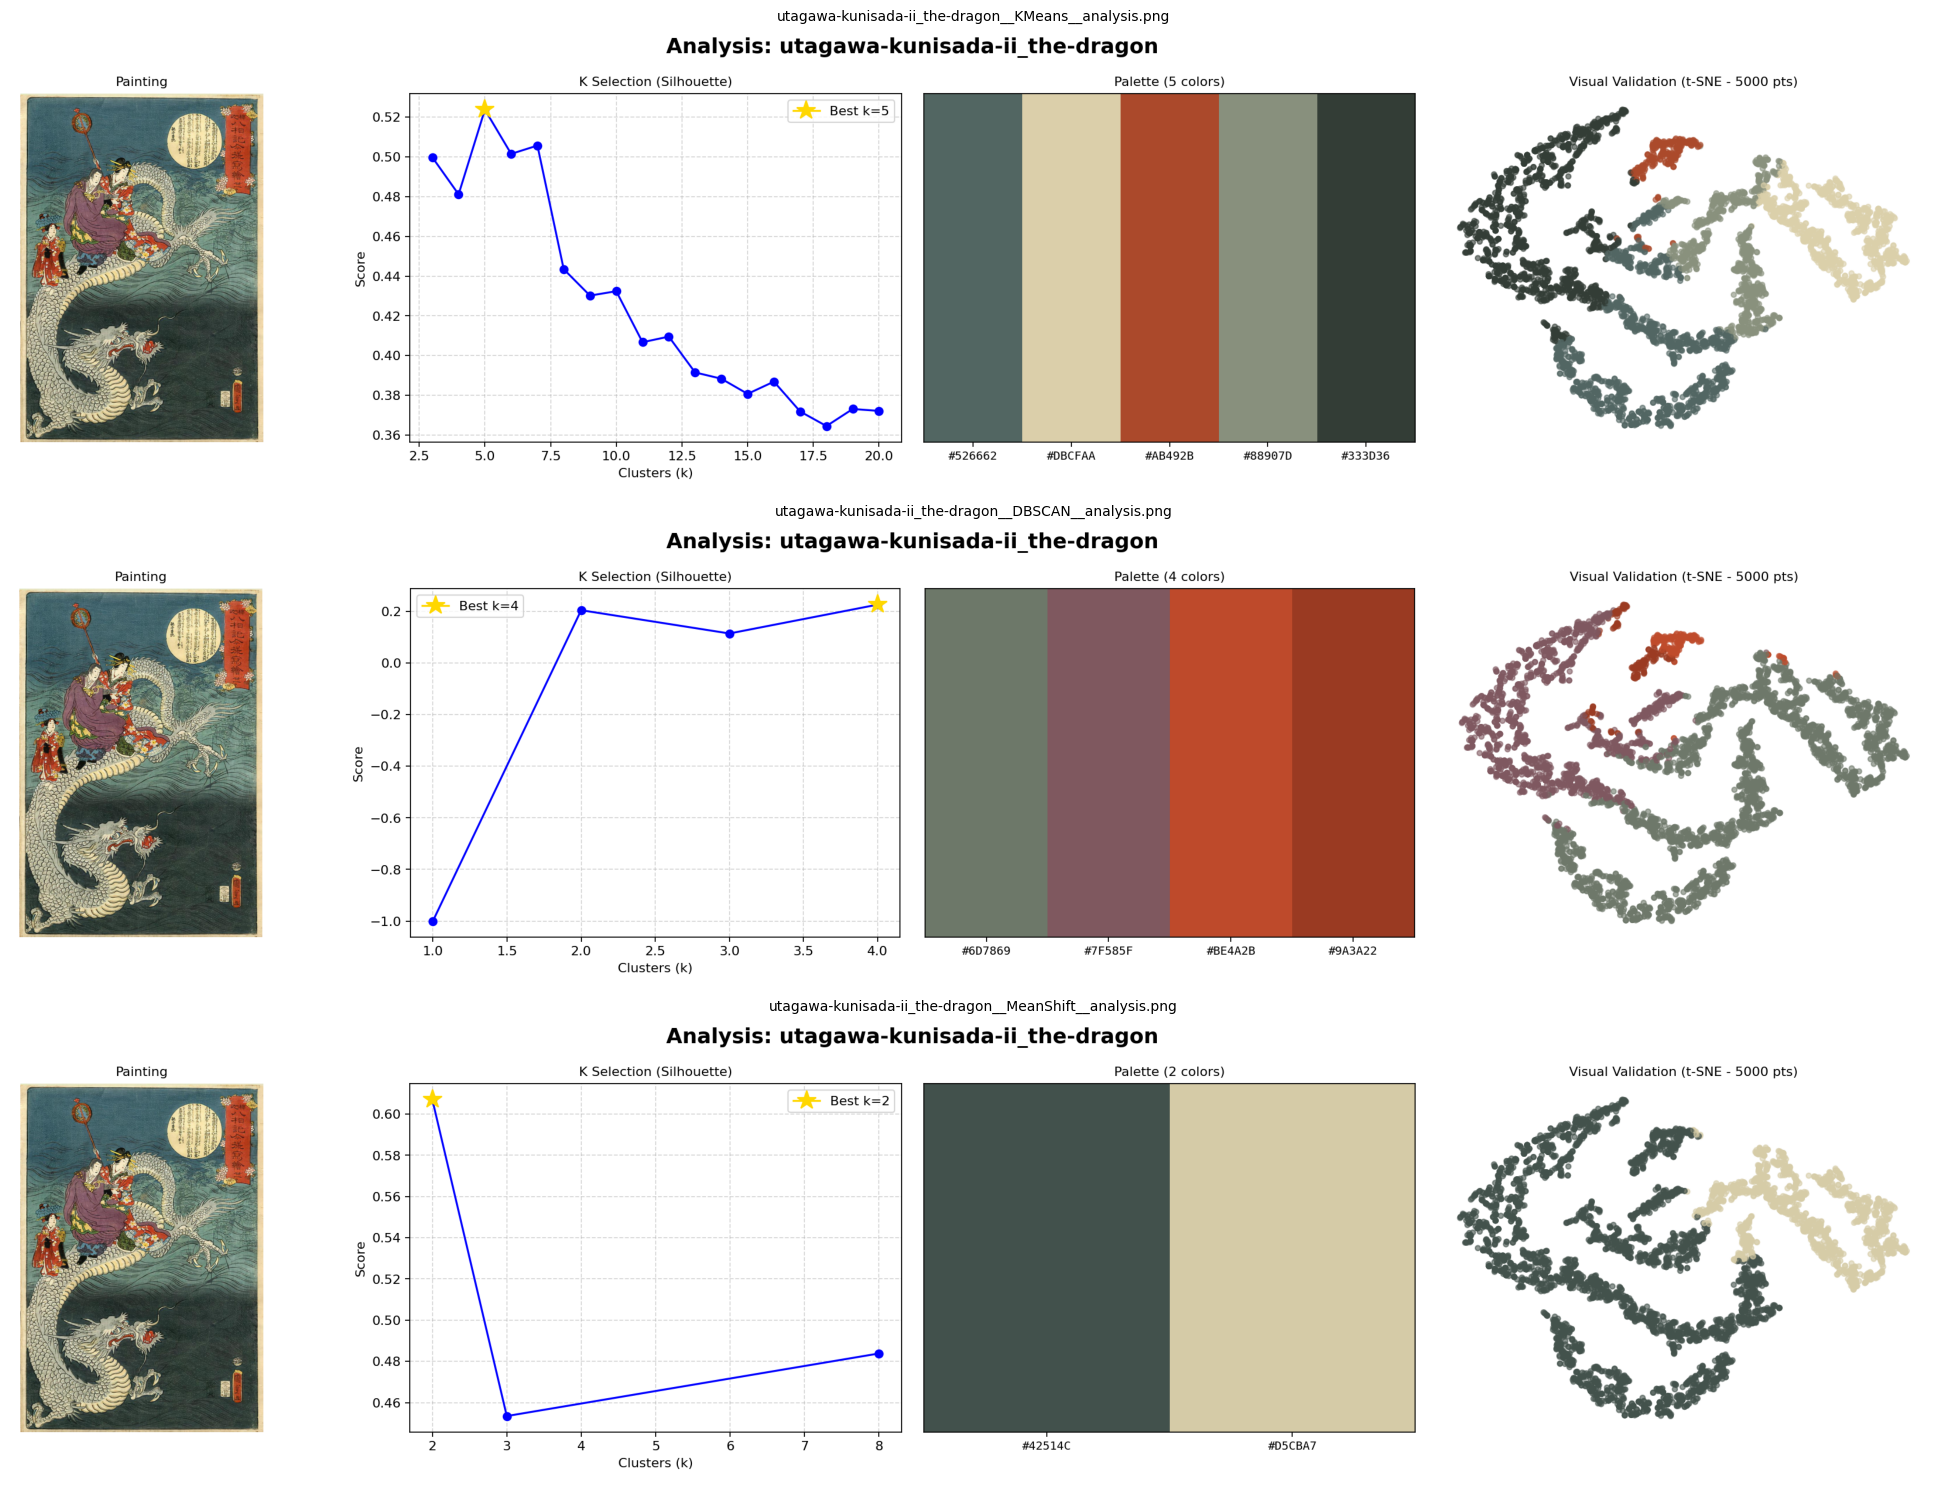

In [20]:
show_three_reports(dragon)

La obra presenta una **estructura cromática altamente compleja y fragmentada**, con una combinación de **colores saturados, contrastes fuertes y variaciones locales intensas**. A diferencia de composiciones geométricas planas o de gradientes suaves, aquí domina una **heterogeneidad cromática pronunciada**, con múltiples tonos coexistiendo en proximidad espacial. Esta complejidad hace que las diferencias entre los algoritmos de clustering se manifiesten de forma particularmente clara, ya que cada uno responde de manera distinta al ruido, la fragmentación y la densidad del color.


#### K-Means (k óptimo ≈ 8–10)


- Cada cluster captura un **color dominante recurrente**, pero no necesariamente regiones visuales coherentes.

K-Means fuerza una partición global del espacio de color alrededor de centroides, sin considerar densidad ni continuidad espacial. En *Dragon*, donde los colores:
- aparecen intercalados,
- presentan alta variabilidad local,

el algoritmo se ve obligado a **promediar tonos cercanos**, generando centroides que representan colores “típicos” pero perdiendo información contextual. Cuando k es bajo, se mezclan colores perceptualmente distintos; al aumentar k, el modelo mejora la separación cromática, pero a costa de **fragmentar excesivamente** el espacio, lo que explica la meseta y posterior caída del Silhouette.


#### DBSCAN (clusters efectivos ≈ 2–3)

- DBSCAN identifica **muy pocos clusters densos**, a pesar de la riqueza cromática.
- Gran parte de los píxeles quedan absorbidos en clusters grandes o tratados implícitamente como ruido.


DBSCAN depende de la existencia de **regiones densas bien definidas** en el espacio de color. En esta obra:
- la distribución cromática es dispersa,
- no hay acumulaciones dominantes suficientemente compactas.

Como resultado, el algoritmo colapsa múltiples colores en uno o dos clusters principales, ignorando matices menos frecuentes. Esto produce una segmentación **extremadamente estable pero poco expresiva**, evidenciando cómo DBSCAN prioriza estructura estadística fuerte y penaliza diversidad cromática distribuida.


#### Mean Shift (k óptimo ≈ 15–20)

- Mean Shift alcanza su mejor desempeño con un **número elevado de clusters**.
- La paleta resultante es rica y diversa, capturando:
  - microvariaciones de tono,
  - transiciones locales abruptas,
  - colores minoritarios pero perceptualmente relevantes.


Mean Shift identifica **modos locales de densidad** sin imponer un número fijo de clusters. En una imagen como *Dragon*, con muchos máximos locales en el espacio de color, el algoritmo:
- detecta numerosos centros válidos,
- interpreta la variabilidad cromática como estructura real.

Esto conduce a una **segmentación fina y detallada**, donde cada cluster representa un subconjunto coherente de color. El descenso gradual del Silhouette refleja que, aunque los clusters adicionales son consistentes localmente, la separación global entre ellos se reduce conforme aumenta la granularidad.

#### Conclusión

- **K-Means** ofrece una representación global razonable, pero sufre ante la fragmentación cromática y la ausencia de bloques dominantes.
- **DBSCAN** falla en capturar la riqueza del color debido a la falta de densidades claras, revelando su sesgo hacia estructuras simples.
- **Mean Shift** es el que mejor se adapta a la complejidad de la obra, exponiendo la **microestructura cromática** inherente a la composición.

En *Dragon*, la alta variabilidad y el contraste intenso hacen que las **limitaciones y supuestos internos de cada algoritmo queden explícitamente reflejados en los resultados**, convirtiendo esta obra en un caso límite ideal para evaluar clustering cromático en escenarios de alta complejidad visual.
